# Analysis of Logistic Regression models trained with _all_ features (trad + arg)

+ on 10000 instances
+ on same splits as for the transformers models

In [1]:
import os
import json
import pandas as pd
import pprint as pp

In [2]:
PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
STATS_DIR = os.path.join(PROJECT_DIR, "classification/stats/")

PROJECT_DIR

'/mount/studenten-temp1/users/dpgo/xai-thesis'

In [3]:
run_file_map = {
    'col-kbest-rfe': os.path.join(STATS_DIR, "12091031_col-kbest-rfe_all_10000.json"),
    'col-kbest-rfe-ensemble': os.path.join(STATS_DIR, "12091031_col-kbest-rfe-ensemble_all_10000.json"),
    'col-rfe': os.path.join(STATS_DIR, "12091031_col-rfe_all_10000.json"),
    'kbest-rfe': os.path.join(STATS_DIR, "12091031_kbest-rfe_all_10000.json"),
    'rfe': os.path.join(STATS_DIR, "12091031_rfe_all_10000.json"),
    'rfe-kbest-ensemble': os.path.join(STATS_DIR, "12091031_rfe-kbest-ensemble_all_10000.json"),
    'rfe-kbest-ensemble-x2': os.path.join(STATS_DIR, "12091031_rfe-kbest-ensemble-x2_all_10000.json"),
    'rfe-kbest-rfe': os.path.join(STATS_DIR, "12091031_rfe-kbest-rfe_all_10000.json"),
    'rfe-x2': os.path.join(STATS_DIR, "12091031_rfe-x2_all_10000.json"),
}

In [4]:
def visualize_results(stats_file, n_features=10):
    
    # load file with results
    with open(os.path.join(PROJECT_DIR, stats_file), "r") as f:
        stats = json.load(f)
        coef_dict, scores_dict = stats['coefficients'], stats['scores']

    # metrics
    # round floats in scores_dict to 2 decimals
    for key, value in scores_dict.items():
        if isinstance(value, float):
            scores_dict[key] = round(value, 2)
        elif isinstance(value, dict):
            for inner_key, inner_value in value.items():
                if isinstance(inner_value, float):
                    scores_dict[key][inner_key] = round(inner_value, 2)
                if inner_key == 'support':
                    scores_dict[key][inner_key] = int(inner_value)
    
    #pp.pprint(scores_dict, indent=4)
    
    # feature importances
    coef_df = pd.DataFrame(coef_dict.items(), columns=['feature', 'coefficient'])
    coef_df = coef_df.sort_values(by='coefficient', ascending=False)

    top_n_pos_features = coef_df.head(n_features)
    top_n_neg_features = coef_df.tail(n_features)
    top_features_df = pd.merge(top_n_pos_features, top_n_neg_features, how='outer')

    top_features_df.plot(
        x='feature', 
        y='coefficient', 
        kind='barh', 
        figsize=(20, 10), 
        color=(top_features_df['coefficient'] > 0).map(
            {True: 'tab:orange', False: 'tab:blue'})
        ).legend(
            loc = 'upper right'
        )

    return top_features_df

## No collinear features + Recursive Feature Elimination (RFE)

Removing collinear features removes features that are otherwise considered important (cogency), meaning they are highly correlated with other features.

| | precision | recall | f1-score | support |
| --- | --- | --- | --- | --- |
| accuracy | 0.72 | | | 1000.0 |
| macro avg | 0.71 | 0.68 | 0.69 | 1000.0 |
| weighted avg | 0.72 | 0.72 | 0.71 | 1000.0 |
| False | 0.68 | 0.5 | 0.58 | 378.0 |
| True | 0.74 | 0.86 | 0.79 | 622.0 |

#### Number of features = 299

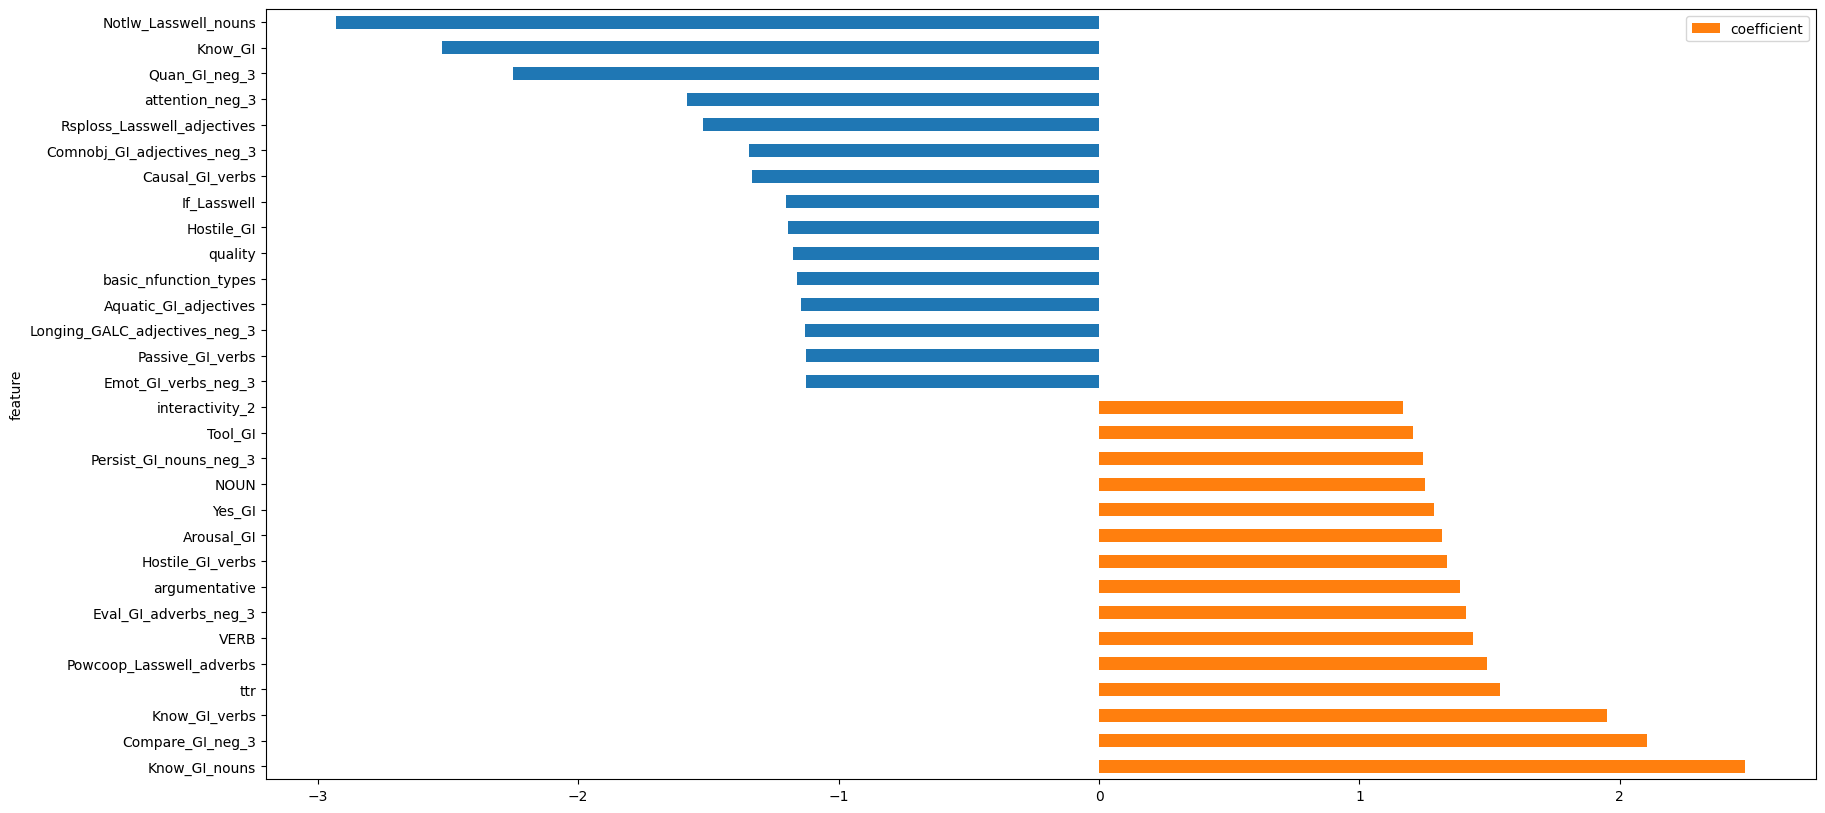

In [7]:
top_col_rfe = visualize_results(run_file_map['col-rfe'], n_features=15)
#top_col_rfe

## RFE only

best model

prediction-based selection only

|          | precision | recall | f1-score | support |
|----------|-----------|--------|----------|---------|
| accuracy | 0.72      |        |          | 1000.0  |
| macro avg | 0.70      | 0.69   | 0.69     | 1000.0  |
| weighted avg | 0.71   | 0.72   | 0.71     | 1000.0  |
| False    | 0.65      | 0.55   | 0.60     | 378.0   |
| True     | 0.75      | 0.82   | 0.78     | 622.0   |

#### Number of features = 711

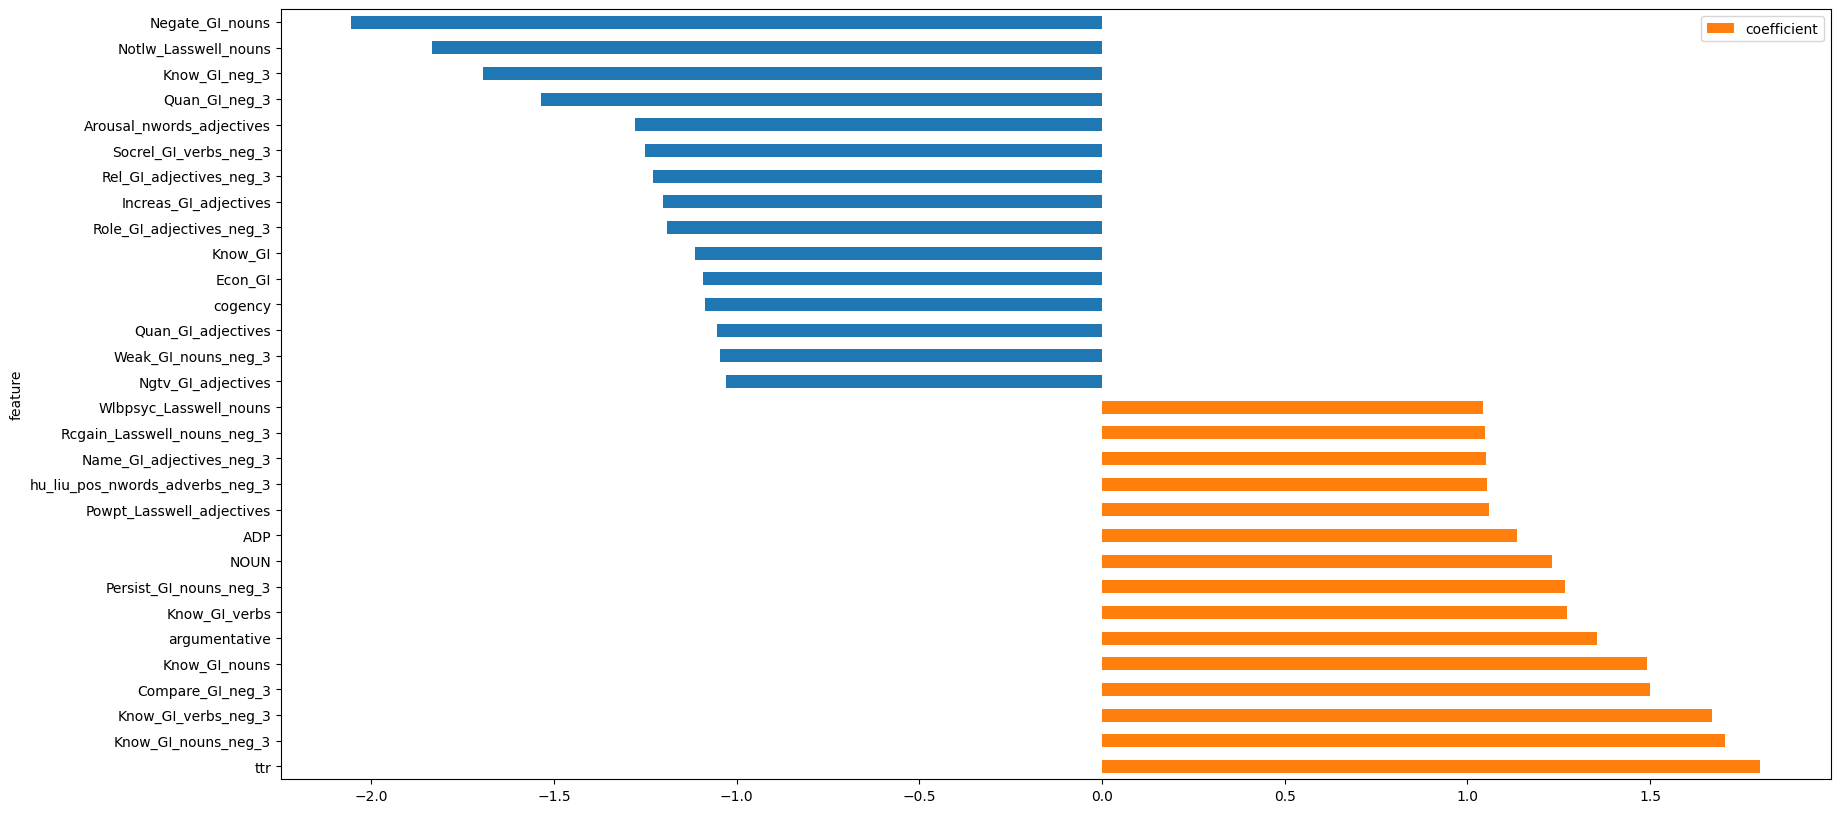

In [8]:
top_rfe = visualize_results(run_file_map['rfe'], n_features=15)
#top_rfe

## RFE + KBest Selection (chi2); Ensemble

throrough feature selection
+ kbest runs chi2 test
+ RFE is prediction based
+ the two sets are ensembled (only features that appear in both sets are kept)


|          | precision | recall | f1-score | support |
|----------|-----------|--------|----------|---------|
| accuracy | 0.70      |        |          | 1000    |
| macro avg | 0.67      | 0.66   | 0.66     | 1000    |
| weighted avg | 0.69   | 0.70   | 0.69     | 1000    |
| False    | 0.62      | 0.49   | 0.55     | 378     |
| True     | 0.73      | 0.82   | 0.77     | 622     |

#### Number of features = 650

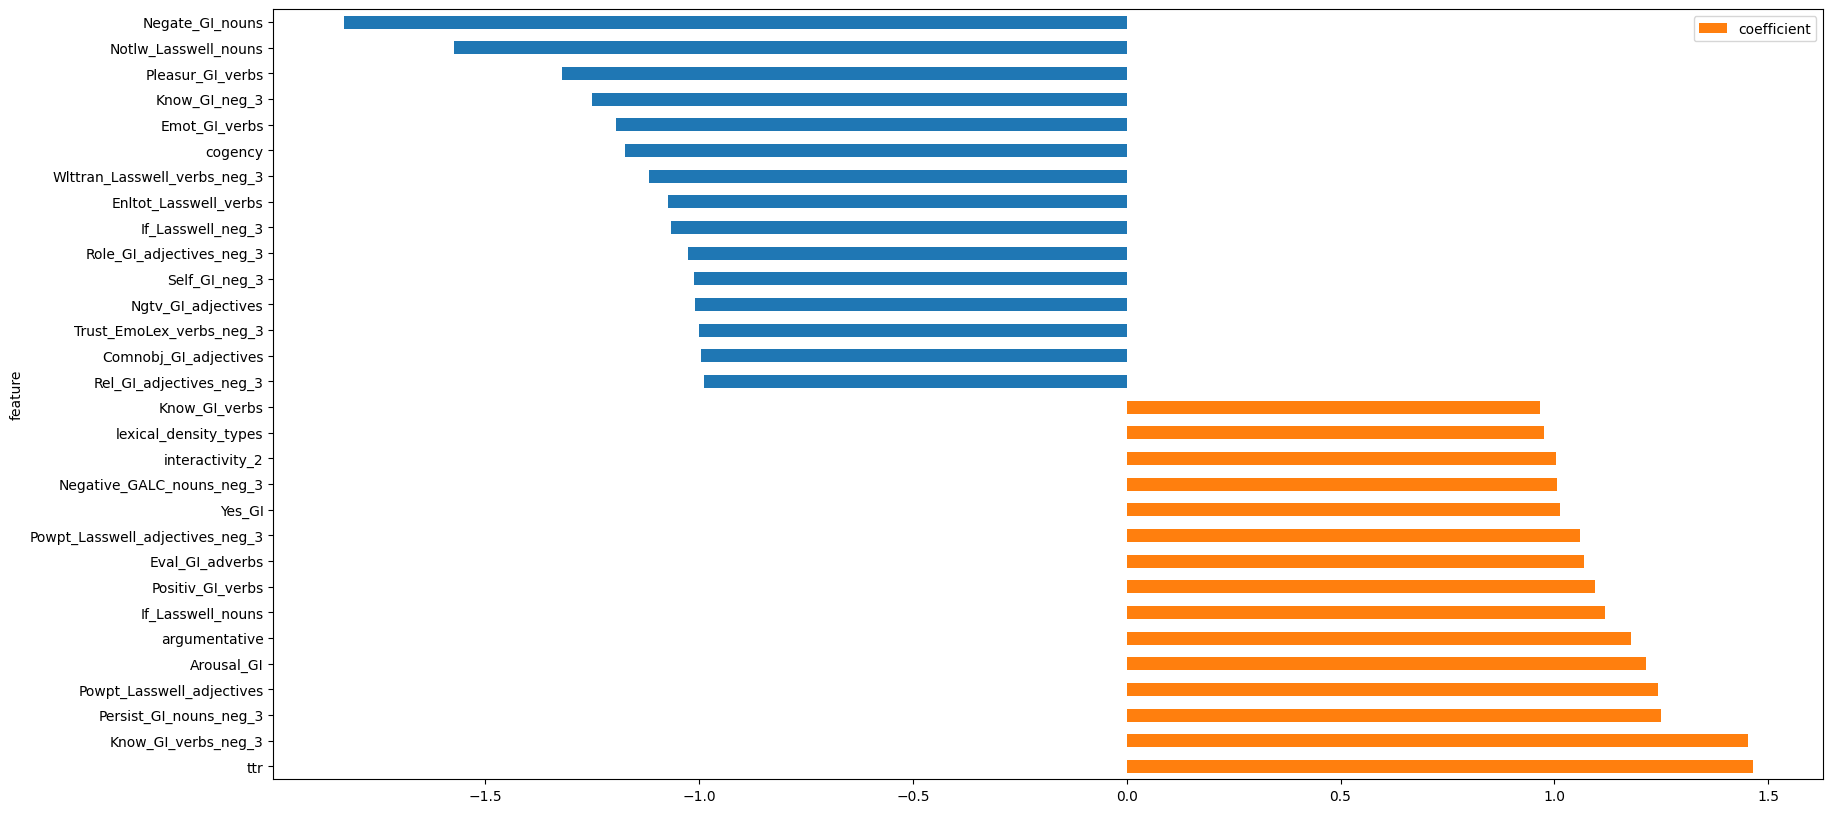

In [9]:
top_rfe_kbest_ensemble = visualize_results(run_file_map['rfe-kbest-ensemble'], n_features=15)

## KBest Selection (chi2) + RFE; Sequential

|          | precision | recall | f1-score | support |
|----------|-----------|--------|----------|---------|
| accuracy | 0.70      |        |          | 1000.0  |
| macro avg | 0.68      | 0.65   | 0.66     | 1000.0  |
| weighted avg | 0.69   | 0.70   | 0.69     | 1000.0  |
| False    | 0.64      | 0.47   | 0.54     | 378.0   |
| True     | 0.72      | 0.84   | 0.78     | 622.0   |

#### Number of features = 355

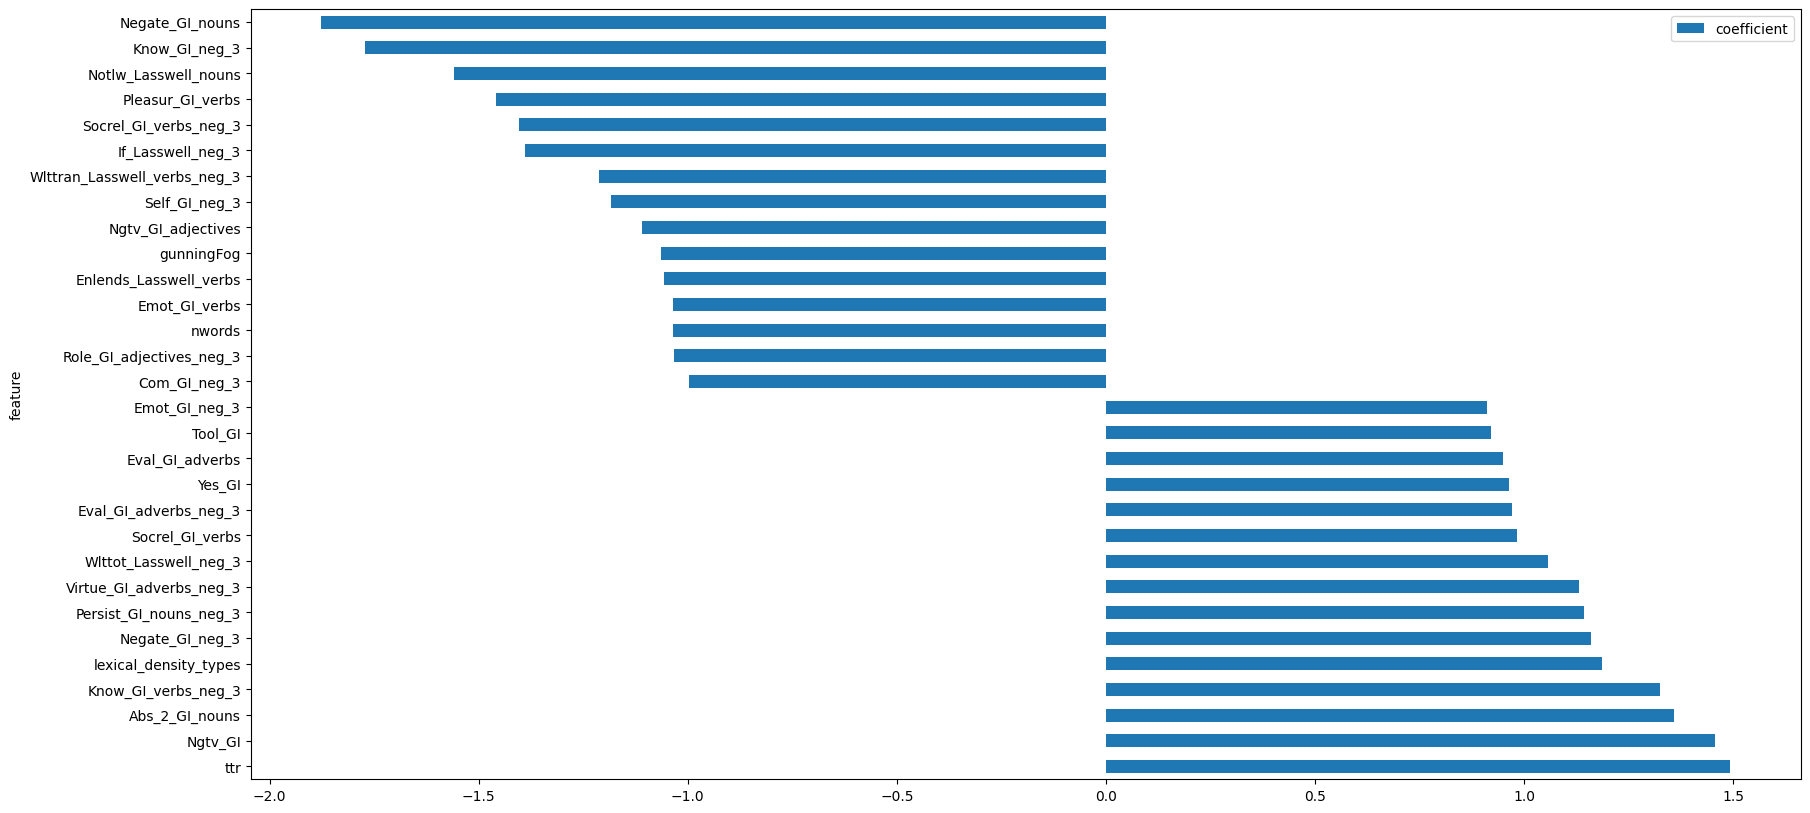

In [8]:
top_kbest_rfe = visualize_results(run_file_map['kbest-rfe'], n_features=15)
#top_kbest_rfe

## RFE + KBest (chi2) + RFE (&rarr; fewer features)

|          | precision | recall | f1-score | support |
|----------|-----------|--------|----------|---------|
| accuracy | 0.69      |        |          | 1000.0  |
| macro avg | 0.67      | 0.64   | 0.64     | 1000.0  |
| weighted avg | 0.68   | 0.69   | 0.68     | 1000.0  |
| False    | 0.63      | 0.43   | 0.51     | 378.0   |
| True     | 0.71      | 0.85   | 0.77     | 622.0   |

#### Number of features = 106

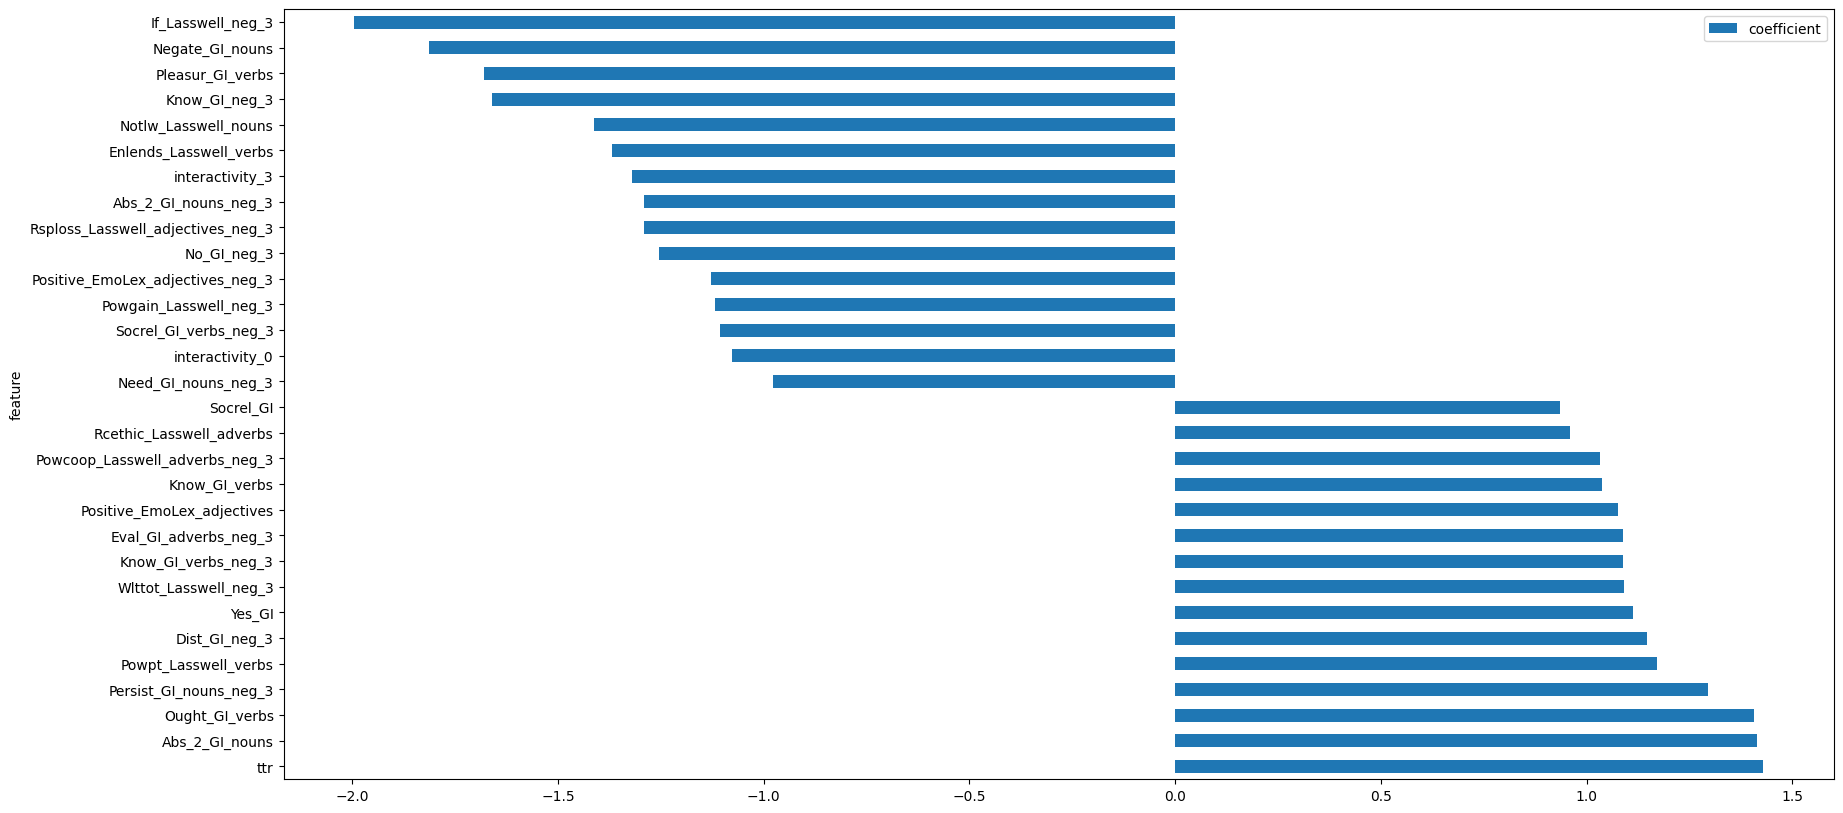

In [9]:
top_rfe_kbest_rfe = visualize_results(run_file_map['rfe-kbest-rfe'], n_features=15)
#top_rfe_kbest_rfe

# Feature analsyis

## Negative

In [10]:
negative_indicators_df = pd.DataFrame()
negative_indicators_df['col-rfe'] = top_col_rfe['feature'].tail(15)
negative_indicators_df['rfe'] = top_rfe['feature'].tail(15)
negative_indicators_df['rfe-kbest-ensemble'] = top_rfe_kbest_ensemble['feature'].tail(15)
negative_indicators_df['kbest-rfe'] = top_kbest_rfe['feature'].tail(15)
negative_indicators_df['rfe-kbest-rfe'] = top_rfe_kbest_rfe['feature'].tail(15)

negative_indicators_df.tail(10) # strongest negative indicators are at the bottom

,col-rfe,rfe,rfe-kbest-ensemble,kbest-rfe,rfe-kbest-rfe
20,quality,Know_GI,Role_GI_adjectives_neg_3,gunningFog,No_GI_neg_3
21,Hostile_GI,Role_GI_adjectives_neg_3,If_Lasswell_neg_3,Ngtv_GI_adjectives,Rsploss_Lasswell_adjectives_neg_3
22,If_Lasswell,Increas_GI_adjectives,Enltot_Lasswell_verbs,Self_GI_neg_3,Abs_2_GI_nouns_neg_3
23,Causal_GI_verbs,Rel_GI_adjectives_neg_3,Wlttran_Lasswell_verbs_neg_3,Wlttran_Lasswell_verbs_neg_3,interactivity_3
24,Comnobj_GI_adjectives_neg_3,Socrel_GI_verbs_neg_3,cogency,If_Lasswell_neg_3,Enlends_Lasswell_verbs
25,Rsploss_Lasswell_adjectives,Arousal_nwords_adjectives,Emot_GI_verbs,Socrel_GI_verbs_neg_3,Notlw_Lasswell_nouns
26,attention_neg_3,Quan_GI_neg_3,Know_GI_neg_3,Pleasur_GI_verbs,Know_GI_neg_3
27,Quan_GI_neg_3,Know_GI_neg_3,Pleasur_GI_verbs,Notlw_Lasswell_nouns,Pleasur_GI_verbs
28,Know_GI,Notlw_Lasswell_nouns,Notlw_Lasswell_nouns,Know_GI_neg_3,Negate_GI_nouns
29,Notlw_Lasswell_nouns,Negate_GI_nouns,Negate_GI_nouns,Negate_GI_nouns,If_Lasswell_neg_3


In [18]:
for df in [top_col_rfe, top_rfe, top_rfe_kbest_ensemble]:
    df = df.tail(10)
    # normalize coefficients between 0 and 1
    df['coefficient'] = (df['coefficient'] - df['coefficient'].min()) / (df['coefficient'].max() - df['coefficient'].min())
    break

/tmp/ipykernel_2408710/1105258214.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coefficient'] = (df['coefficient'] - df['coefficient'].min()) / (df['coefficient'].max() - df['coefficient'].min())


In [11]:
# for each possible values in the df (features), count how many times it appears across all columns 
frequency_neg_df = negative_indicators_df.tail(10).apply(pd.value_counts).fillna(0).sum(axis=1).sort_values(ascending=False)
frequency_neg_df[frequency_neg_df >= 2] # show only features that appear at least twice as negative indicators

Notlw_Lasswell_nouns            5.0
Negate_GI_nouns                 4.0
Know_GI_neg_3                   4.0
If_Lasswell_neg_3               3.0
Pleasur_GI_verbs                3.0
Know_GI                         2.0
Role_GI_adjectives_neg_3        2.0
Quan_GI_neg_3                   2.0
Socrel_GI_verbs_neg_3           2.0
Wlttran_Lasswell_verbs_neg_3    2.0
dtype: float64

In [15]:
'''Only look at three set'''
small_negative_indicators_df = negative_indicators_df[['col-rfe', 'rfe', 'rfe-kbest-ensemble']]
small_negative_indicators_df.tail(10).apply(pd.value_counts).fillna(0).sum(axis=1).sort_values(ascending=False)


Notlw_Lasswell_nouns            3.0
Negate_GI_nouns                 2.0
Role_GI_adjectives_neg_3        2.0
Know_GI                         2.0
Know_GI_neg_3                   2.0
Quan_GI_neg_3                   2.0
Pleasur_GI_verbs                1.0
cogency                         1.0
attention_neg_3                 1.0
Wlttran_Lasswell_verbs_neg_3    1.0
Socrel_GI_verbs_neg_3           1.0
Rsploss_Lasswell_adjectives     1.0
Rel_GI_adjectives_neg_3         1.0
Arousal_nwords_adjectives       1.0
Causal_GI_verbs                 1.0
Increas_GI_adjectives           1.0
If_Lasswell_neg_3               1.0
If_Lasswell                     1.0
Hostile_GI                      1.0
Enltot_Lasswell_verbs           1.0
Emot_GI_verbs                   1.0
Comnobj_GI_adjectives_neg_3     1.0
quality                         1.0
dtype: float64

In [27]:
weighted_ranking = {}
for df in [top_col_rfe, top_rfe, top_rfe_kbest_ensemble]:
    df = df.tail(15)
    # scale coefficients to values between 0 and 1
    df['coefficient'] = (df['coefficient'] - df['coefficient'].min()) / (df['coefficient'].max() - df['coefficient'].min())
    for i, feature in enumerate(df['feature']):
        if feature not in weighted_ranking:
            weighted_ranking[feature] = 0
        weighted_ranking[feature] += df[df['feature'] == feature]['coefficient'].values[0]

# sort weighted ranking by value
sorted_weighted_ranking = sorted(weighted_ranking.items(), key=lambda kv: kv[1], reverse=False)
sorted_weighted_ranking

/tmp/ipykernel_2408710/1057340652.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coefficient'] = (df['coefficient'] - df['coefficient'].min()) / (df['coefficient'].max() - df['coefficient'].min())


[('Negate_GI_nouns', 0.0),
 ('Notlw_Lasswell_nouns', 0.5244373029707432),
 ('Pleasur_GI_verbs', 0.6056238453911194),
 ('attention_neg_3', 0.7468310301307024),
 ('Emot_GI_verbs', 0.7569099955095377),
 ('Arousal_nwords_adjectives', 0.7586332044901416),
 ('Rsploss_Lasswell_adjectives', 0.7788690519035277),
 ('Socrel_GI_verbs_neg_3', 0.7857451563656044),
 ('Increas_GI_adjectives', 0.8319998250620546),
 ('Wlttran_Lasswell_verbs_neg_3', 0.8479816143925996),
 ('Comnobj_GI_adjectives_neg_3', 0.8775875699214997),
 ('Quan_GI_neg_3', 0.8804405824634451),
 ('Causal_GI_verbs', 0.8834493418035511),
 ('Enltot_Lasswell_verbs', 0.9002192128370076),
 ('If_Lasswell_neg_3', 0.9098919921867927),
 ('Econ_GI', 0.9399301477008295),
 ('If_Lasswell', 0.9570834747234201),
 ('Hostile_GI', 0.9602756854478327),
 ('quality', 0.9718616362728951),
 ('Self_GI_neg_3', 0.9726290126042221),
 ('Quan_GI_adjectives', 0.9777895245951156),
 ('basic_nfunction_types', 0.979038696200604),
 ('Weak_GI_nouns_neg_3', 0.98595849616431

In [38]:
PREDS_DIR = os.path.join(PROJECT_DIR, "classification/preds/")
SPLITS_DIR = os.path.join(PROJECT_DIR, "classification/split_datasets/coqa")
FEATURES_DIR = os.path.join(PROJECT_DIR, "feature_extraction/features")

# focus on two best models (col-rfe and rfe)
preds_file_col_rfe = os.path.join(PREDS_DIR, "preds_12091031_col-rfe_all.json")
preds_file_rfe = os.path.join(PREDS_DIR, "preds_12091031_rfe_all.json")

arg_features_file = os.path.join(FEATURES_DIR, "12091031_all_features.csv.gz")

from datasets import load_from_disk
test_data = load_from_disk(os.path.join(SPLITS_DIR))['test']

In [36]:
features_df = pd.read_csv(arg_features_file, compression='gzip')
features_test_df = features_df[features_df['idx'].isin(test_data['pandas_idx'])]

In [39]:
preds_col_rfe = pd.read_json(preds_file_col_rfe, orient='index')
preds_col_rfe.columns = ['pred']
preds_col_rfe['pred'] = preds_col_rfe['pred'].astype(int)

preds_rfe = pd.read_json(preds_file_rfe, orient='index')
preds_rfe.columns = ['pred']
preds_rfe['pred'] = preds_rfe['pred'].astype(int)

features_test_col_rfe_df = pd.merge(features_test_df, preds_col_rfe, how='outer', left_index=True, right_index=True)
features_test_rfe_df = pd.merge(features_test_df, preds_rfe, how='outer', left_index=True, right_index=True)

In [40]:
features_test_col_rfe_df['pred'].value_counts() # general distribution of predictions

pred
1    720
0    280
Name: count, dtype: int64

In [41]:
features_test_rfe_df['pred'].value_counts() # general distribution of predictions

pred
1    683
0    317
Name: count, dtype: int64

In [66]:
# correlations for col-rfe
features_test_col_rfe_df[['Notlw_Lasswell_nouns', 'Negate_GI_nouns', 'Know_GI_neg_3', 'If_Lasswell_neg_3', 'Pleasur_GI_verbs', 'Know_GI', 'Role_GI_adjectives_neg_3', 'Quan_GI_neg_3', 'Socrel_GI_verbs_neg_3', 'pred']].corr()

,Notlw_Lasswell_nouns,Negate_GI_nouns,Know_GI_neg_3,If_Lasswell_neg_3,Pleasur_GI_verbs,Know_GI,Role_GI_adjectives_neg_3,Quan_GI_neg_3,Socrel_GI_verbs_neg_3,pred
Notlw_Lasswell_nouns,1.000000,0.720277,0.031296,0.005157,-0.007234,0.026252,-0.014055,0.081541,0.012391,-0.032265
Negate_GI_nouns,0.720277,1.000000,0.068657,0.026555,0.017460,0.067936,-0.021917,0.102328,0.034716,-0.040822
Know_GI_neg_3,0.031296,0.068657,1.000000,0.185248,0.018683,0.959091,0.017940,0.209199,0.018389,-0.185723
If_Lasswell_neg_3,0.005157,0.026555,0.185248,1.000000,0.023639,0.171746,-0.031855,0.073976,0.111506,-0.338000
Pleasur_GI_verbs,-0.007234,0.017460,0.018683,0.023639,1.000000,0.019201,0.001266,0.012361,0.001360,-0.064812
Know_GI,0.026252,0.067936,0.959091,0.171746,0.019201,1.000000,0.032506,0.204275,0.017736,-0.159676
Role_GI_adjectives_neg_3,-0.014055,-0.021917,0.017940,-0.031855,0.001266,0.032506,1.000000,-0.034864,0.059507,-0.020887
Quan_GI_neg_3,0.081541,0.102328,0.209199,0.073976,0.012361,0.204275,-0.034864,1.000000,-0.109066,-0.121476
Socrel_GI_verbs_neg_3,0.012391,0.034716,0.018389,0.111506,0.001360,0.017736,0.059507,-0.109066,1.000000,-0.176255
pred,-0.032265,-0.040822,-0.185723,-0.338000,-0.064812,-0.159676,-0.020887,-0.121476,-0.176255,1.000000


In [98]:
# correlations for rfe
features_test_rfe_df[['Notlw_Lasswell_nouns', 'Negate_GI_nouns', 'Know_GI_neg_3', 'If_Lasswell_neg_3', 'Pleasur_GI_verbs', 'Know_GI', 'Role_GI_adjectives_neg_3', 'Quan_GI_neg_3', 'Socrel_GI_verbs_neg_3', 'pred']].corr()

,Notlw_Lasswell_nouns,Negate_GI_nouns,Know_GI_neg_3,If_Lasswell_neg_3,Pleasur_GI_verbs,Know_GI,Role_GI_adjectives_neg_3,Quan_GI_neg_3,Socrel_GI_verbs_neg_3,pred
Notlw_Lasswell_nouns,1.000000,0.720277,0.031296,0.005157,-0.007234,0.026252,-0.014055,0.081541,0.012391,-0.099797
Negate_GI_nouns,0.720277,1.000000,0.068657,0.026555,0.017460,0.067936,-0.021917,0.102328,0.034716,-0.076581
Know_GI_neg_3,0.031296,0.068657,1.000000,0.185248,0.018683,0.959091,0.017940,0.209199,0.018389,-0.158174
If_Lasswell_neg_3,0.005157,0.026555,0.185248,1.000000,0.023639,0.171746,-0.031855,0.073976,0.111506,-0.338257
Pleasur_GI_verbs,-0.007234,0.017460,0.018683,0.023639,1.000000,0.019201,0.001266,0.012361,0.001360,-0.080983
Know_GI,0.026252,0.067936,0.959091,0.171746,0.019201,1.000000,0.032506,0.204275,0.017736,-0.137107
Role_GI_adjectives_neg_3,-0.014055,-0.021917,0.017940,-0.031855,0.001266,0.032506,1.000000,-0.034864,0.059507,-0.043146
Quan_GI_neg_3,0.081541,0.102328,0.209199,0.073976,0.012361,0.204275,-0.034864,1.000000,-0.109066,-0.117090
Socrel_GI_verbs_neg_3,0.012391,0.034716,0.018389,0.111506,0.001360,0.017736,0.059507,-0.109066,1.000000,-0.169781
pred,-0.099797,-0.076581,-0.158174,-0.338257,-0.080983,-0.137107,-0.043146,-0.117090,-0.169781,1.000000


### Notlw_Lasswell_nouns

In [69]:
features_df['Notlw_Lasswell_nouns'].describe()

count    10000.000000
mean         0.001729
std          0.010907
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.333333
Name: Notlw_Lasswell_nouns, dtype: float64

In [47]:
features_test_df.loc[features_test_df['Notlw_Lasswell_nouns'] == 0].shape[0] # zero values

952

In [48]:
features_df.loc[features_df['Notlw_Lasswell_nouns'] == 0].shape[0] # zero values in full dataset (out of 10000)

9584

#### col-RFE

In [143]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Notlw_Lasswell_nouns'] > 0.0]['pred'].value_counts() # non-zero (out of 280 negative preds)

pred
1    29
0    19
Name: count, dtype: int64

In [56]:
# instances with non-zero values (there are no possible negative values)
features_test_col_rfe_df.loc[features_test_col_rfe_df['Notlw_Lasswell_nouns'] > 0]['pred'].value_counts()

pred
1    29
0    19
Name: count, dtype: int64

In [91]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Notlw_Lasswell_nouns'] > 0.04]['pred'].value_counts() # higher values

pred
1    11
0     7
Name: count, dtype: int64

In [86]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Notlw_Lasswell_nouns'] > 0.12]['pred'].value_counts() # highest values

pred
1    2
Name: count, dtype: int64

Notlw_Lasswell_nouns appears as a strong indicator of the negative class, but when looking at instances with high values most of them are positive predictions... (and the really high values are positive predictions)

#### RFE

In [144]:
features_test_rfe_df.loc[features_test_rfe_df['Notlw_Lasswell_nouns'] > 0.0]['pred'].value_counts() # non zero (out of 317 negative preds)

pred
0    24
1    24
Name: count, dtype: int64

In [88]:
features_test_rfe_df.loc[features_test_rfe_df['Notlw_Lasswell_nouns'] > 0.0018]['pred'].value_counts() # above avg

pred
0    24
1    24
Name: count, dtype: int64

In [89]:
features_test_rfe_df.loc[features_test_rfe_df['Notlw_Lasswell_nouns'] > 0.04]['pred'].value_counts() # higher values

pred
0    9
1    9
Name: count, dtype: int64

In [97]:
features_test_rfe_df.loc[features_test_rfe_df['Notlw_Lasswell_nouns'] > 0.1]['pred'].value_counts() # highest values

pred
0    3
Name: count, dtype: int64

With RFE model, it makes sense that Notlw_Lasswell_nouns is an indicator of the negative class

The highest values are negative preds.


### If_Lasswell_neg_3

In [82]:
features_df['If_Lasswell_neg_3'].describe()

count    10000.000000
mean         0.034417
std          0.026309
min          0.000000
25%          0.015152
50%          0.031250
75%          0.050000
max          0.285714
Name: If_Lasswell_neg_3, dtype: float64

In [83]:
# zero values
features_test_df.loc[features_test_df['If_Lasswell_neg_3'] == 0].shape[0]

153

#### col-RFE

In [139]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['If_Lasswell_neg_3'] > 0]['pred'].value_counts() # non-zero (out of 280 negative preds)

pred
1    577
0    270
Name: count, dtype: int64

In [108]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['If_Lasswell_neg_3'] > 0.034]['pred'].value_counts()

pred
1    256
0    202
Name: count, dtype: int64

In [109]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['If_Lasswell_neg_3'] > 0.1]['pred'].value_counts()

pred
0    8
1    7
Name: count, dtype: int64

RFE

In [140]:
features_test_rfe_df.loc[features_test_rfe_df['If_Lasswell_neg_3'] > 0]['pred'].value_counts() # non-zero (out of 317 negative preds)

pred
1    547
0    300
Name: count, dtype: int64

In [100]:
features_test_rfe_df.loc[features_test_rfe_df['If_Lasswell_neg_3'] > 0.034]['pred'].value_counts() # above avg

pred
1    241
0    217
Name: count, dtype: int64

In [107]:
features_test_rfe_df.loc[features_test_rfe_df['If_Lasswell_neg_3'] > 0.1]['pred'].value_counts() # above avg

pred
0    11
1     4
Name: count, dtype: int64

### Negate_GI_nouns

In [111]:
features_df['Negate_GI_nouns'].describe()

count    10000.000000
mean         0.003860
std          0.017517
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.333333
Name: Negate_GI_nouns, dtype: float64

In [112]:
# zero values
features_test_df.loc[features_test_df['Negate_GI_nouns'] == 0].shape[0]

909

#### col-RFE

In [137]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Negate_GI_nouns'] > 0.0]['pred'].value_counts() # non-zero (out of 280 negative preds)

pred
1    54
0    37
Name: count, dtype: int64

In [113]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Negate_GI_nouns'] > 0.0038]['pred'].value_counts()

pred
1    54
0    37
Name: count, dtype: int64

In [116]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Negate_GI_nouns'] > 0.05]['pred'].value_counts()

pred
1    19
0    11
Name: count, dtype: int64

In [118]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Negate_GI_nouns'] > 0.1]['pred'].value_counts()

pred
1    6
0    2
Name: count, dtype: int64

#### RFE

In [138]:
features_test_rfe_df.loc[features_test_rfe_df['Negate_GI_nouns'] > 0.0]['pred'].value_counts() # non-zero (out of 317 negative preds)

pred
1    49
0    42
Name: count, dtype: int64

In [119]:
features_test_rfe_df.loc[features_test_rfe_df['Negate_GI_nouns'] > 0.0038]['pred'].value_counts() # above avg

pred
1    49
0    42
Name: count, dtype: int64

In [120]:
features_test_rfe_df.loc[features_test_rfe_df['Negate_GI_nouns'] > 0.05]['pred'].value_counts() # higher values

pred
1    15
0    15
Name: count, dtype: int64

In [125]:
features_test_rfe_df.loc[features_test_rfe_df['Negate_GI_nouns'] > 0.10]['pred'].value_counts() # highest values

pred
0    4
1    4
Name: count, dtype: int64

### Know_GI_neg_3

In [126]:
features_df['Know_GI_neg_3'].describe()

count    10000.000000
mean         0.048124
std          0.031275
min          0.000000
25%          0.026316
50%          0.044118
75%          0.066057
max          0.227273
Name: Know_GI_neg_3, dtype: float64

In [127]:
# zero values
features_test_df.loc[features_test_df['Know_GI_neg_3'] == 0].shape[0]

88

#### col-RFE

In [136]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Know_GI_neg_3'] > 0.0]['pred'].value_counts() # non-zero (out of 280 preds)

pred
1    637
0    275
Name: count, dtype: int64

In [128]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Know_GI_neg_3'] > 0.048]['pred'].value_counts()

pred
1    298
0    155
Name: count, dtype: int64

In [129]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Know_GI_neg_3'] > 0.1]['pred'].value_counts()

pred
1    27
0    27
Name: count, dtype: int64

In [131]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Know_GI_neg_3'] > 0.15]['pred'].value_counts()

pred
1    4
0    2
Name: count, dtype: int64

#### RFE

In [135]:
features_test_rfe_df.loc[features_test_rfe_df['Know_GI_neg_3'] > 0.0]['pred'].value_counts() # non zero (out of 317 negative preds)

pred
1    606
0    306
Name: count, dtype: int64

In [132]:
features_test_rfe_df.loc[features_test_rfe_df['Know_GI_neg_3'] > 0.048]['pred'].value_counts() # above avg

pred
1    290
0    163
Name: count, dtype: int64

In [133]:
features_test_rfe_df.loc[features_test_rfe_df['Know_GI_neg_3'] > 0.1]['pred'].value_counts() # above avg

pred
0    28
1    26
Name: count, dtype: int64

In [134]:
features_test_rfe_df.loc[features_test_rfe_df['Know_GI_neg_3'] > 0.15]['pred'].value_counts() # above avg

pred
1    3
0    3
Name: count, dtype: int64

### Pleasure_GI_verbs

In [145]:
features_df['Pleasur_GI_verbs'].describe()

count    10000.000000
mean         0.009057
std          0.028377
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.454545
Name: Pleasur_GI_verbs, dtype: float64

In [146]:
# zero values
features_test_df.loc[features_test_df['Pleasur_GI_verbs'] == 0].shape[0]

858

#### col-RFE

In [147]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Pleasur_GI_verbs'] > 0.0]['pred'].value_counts() # non-zero (out of 280 preds)

pred
1    89
0    53
Name: count, dtype: int64

In [148]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Pleasur_GI_verbs'] > 0.009]['pred'].value_counts() # above avg

pred
1    89
0    53
Name: count, dtype: int64

In [149]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Pleasur_GI_verbs'] > 0.05]['pred'].value_counts() # higher values

pred
1    49
0    28
Name: count, dtype: int64

In [154]:
features_test_col_rfe_df.loc[features_test_col_rfe_df['Pleasur_GI_verbs'] > 0.1]['pred'].value_counts() # highest values

pred
0    9
1    9
Name: count, dtype: int64

#### RFE

In [155]:
features_test_rfe_df.loc[features_test_rfe_df['Pleasur_GI_verbs'] > 0.0]['pred'].value_counts() # non zero (out of 317 negative preds)

pred
1    83
0    59
Name: count, dtype: int64

In [156]:
features_test_rfe_df.loc[features_test_rfe_df['Pleasur_GI_verbs'] > 0.009]['pred'].value_counts() # above avg

pred
1    83
0    59
Name: count, dtype: int64

In [157]:
features_test_rfe_df.loc[features_test_rfe_df['Pleasur_GI_verbs'] > 0.05]['pred'].value_counts() # higher values

pred
1    45
0    32
Name: count, dtype: int64

In [158]:
features_test_rfe_df.loc[features_test_rfe_df['Pleasur_GI_verbs'] > 0.1]['pred'].value_counts() # highest values

pred
0    9
1    9
Name: count, dtype: int64